In [12]:
#hide
from utils import *

# Image classification

## From dogs and cats, to pet breeds

In [13]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)

In [14]:
#hide
Path.BASE_PATH = path

In [15]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [16]:
(path/"images").ls()

(#7393) [Path('images/american_bulldog_146.jpg'),Path('images/japanese_chin_12.jpg'),Path('images/Sphynx_247.jpg'),Path('images/beagle_158.jpg'),Path('images/beagle_76.jpg'),Path('images/shiba_inu_207.jpg'),Path('images/Siamese_56.jpg'),Path('images/keeshond_194.jpg'),Path('images/miniature_pinscher_89.jpg'),Path('images/leonberger_42.jpg')...]

In [17]:
fname = (path/"images").ls()[0]

In [18]:
#regular expressions for string patterns
re.findall(r'(.+)_\d+.jpg$', fname.name)

['american_bulldog']

In [19]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), #using_attr passes 'name' to the RegexLabeller Function
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

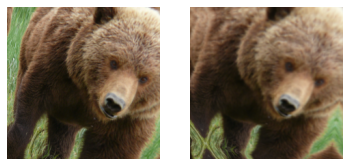

In [20]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and debugging a DataBlock

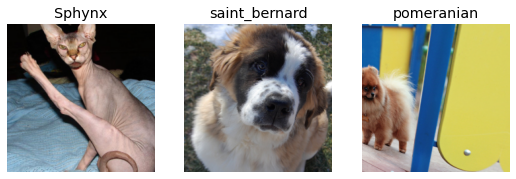

In [21]:
dls.show_batch(nrows = 1, ncols=3)

In [22]:
learn = cnn_learner(dls, resnet34, metrics=error_rate) #no loss function here bc Fast.ai tends to pick one for us
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.497479,0.344495,0.110961,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.518980,0.350329,0.105548,00:31
1,0.332419,0.254876,0.078484,00:31


## Cross entropy loss

### Viewing activations and labels

In [23]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [24]:
#To understand how CE Loss works for DV with 2+ categories we need
#to see/understand what the data/activations seen by the loss look like

In [25]:
x,y = dls.one_batch()

In [26]:
y

TensorCategory([35, 34, 14,  3, 18,  7, 31, 13, 14, 16, 26, 21, 20, 32, 15, 14, 28, 11, 19,  7,  2, 23,  9, 26, 28,  8, 13, 16, 29,  1, 31,  5,  7, 32, 18, 30, 17,  1, 20, 17, 18,  4, 24, 34,  3, 27, 15, 21,
         0, 16, 15, 13, 18, 13, 32, 19, 15, 26,  7, 15,  5, 24,  8, 16], device='cuda:0')

In [27]:
dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

In [28]:
x

TensorImage([[[[-0.8826, -0.9067, -0.9039,  ..., -0.4341, -0.6301, -1.0813],
          [-0.8824, -0.8979, -0.8971,  ..., -0.4034, -0.5650, -0.9814],
          [-0.8808, -0.8828, -0.8815,  ..., -0.3643, -0.5096, -0.9023],
          ...,
          [ 0.5714,  0.5709,  0.5611,  ..., -1.2992, -1.3307, -1.3341],
          [ 0.5785,  0.5647,  0.5190,  ..., -1.2831, -1.3137, -1.3235],
          [ 0.5837,  0.5365,  0.4717,  ..., -1.3033, -1.3273, -1.3335]],

         [[-1.1053, -1.1304, -1.1171,  ..., -0.4735, -0.6781, -1.0621],
          [-1.1051, -1.1228, -1.1219,  ..., -0.4486, -0.6322, -0.9810],
          [-1.1033, -1.1055, -1.1074,  ..., -0.4047, -0.5932, -0.9261],
          ...,
          [ 0.3320,  0.3254,  0.2930,  ..., -1.3683, -1.4032, -1.4070],
          [ 0.3051,  0.2952,  0.2377,  ..., -1.3502, -1.3837, -1.3953],
          [ 0.2814,  0.2592,  0.2007,  ..., -1.3610, -1.3787, -1.3889]],

         [[-1.1694, -1.2041, -1.2120,  ..., -0.4135, -0.6076, -0.9531],
          [-1.1314, -1.15

In [29]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([3.1494e-07, 7.9434e-08, 8.6229e-07, 8.1367e-08, 8.6738e-08, 3.8358e-08, 1.7710e-06, 6.2863e-07, 1.6965e-06, 1.8191e-06, 4.0627e-06, 2.0284e-07, 1.4703e-07, 9.3232e-08, 5.8697e-07, 2.2896e-07,
        6.3337e-07, 3.0564e-07, 2.2426e-06, 1.3614e-07, 3.4182e-08, 3.0860e-05, 2.0998e-05, 1.2295e-08, 2.4359e-08, 1.9473e-07, 8.0042e-08, 2.0603e-08, 1.0591e-07, 1.5718e-05, 6.5100e-08, 7.6100e-07,
        1.5486e-03, 6.0581e-08, 2.8014e-07, 9.9837e-01, 2.3858e-07])

In [30]:
len(preds[0]),preds[0].sum() #grab all predications of our first image. What is the prob. that this is an Abyssianian car

(37, tensor(1.))

### Softmax

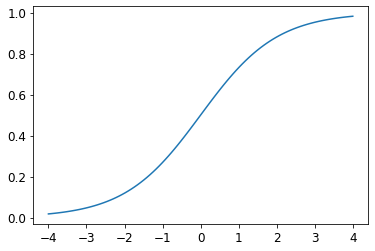

In [31]:
plot_function(torch.sigmoid, min=-4,max=4) 

In [32]:
#hide
torch.random.manual_seed(42);

In [33]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [34]:
acts.sigmoid() 

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [35]:
#Referencing above, each column is an activation representing liklihood that IV is DV

In [36]:
(acts[:,0]-acts[:,1]).sigmoid() #take the difference between aligning values in the two columns and then apply sigmoid

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [37]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log likelihood

In [38]:
targ = tensor([0,1,0,1,1,0])

In [39]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [40]:
idx = range(6)
sm_acts[idx, targ] #which rows should we return, which column should we return

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [41]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [42]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [43]:
F.nll_loss(sm_acts, targ, reduction='none') #negative log liklihood loss is the same as the above indexing trick

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the `log`

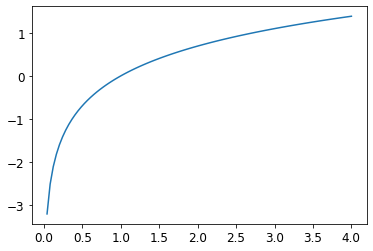

In [44]:
plot_function(torch.log, min=0,max=4)

In [45]:
loss_func = nn.CrossEntropyLoss()

In [46]:
loss_func(acts, targ)

tensor(1.8045)

In [47]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [48]:
nn.CrossEntropyLoss(reduction='none')(acts, targ) #reduction param here disables taking the mean of loss of all items

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

In [49]:
#NLL does not actually take the log, it assumes you already took the log of the softmax
#In pytorch we use log_softmax that combines log and softmax for us, then we can use NLL
#nn.CrossEntropyLoss() takes the log_softmax and then NL_loss for us in one function.

## Model Interpretation

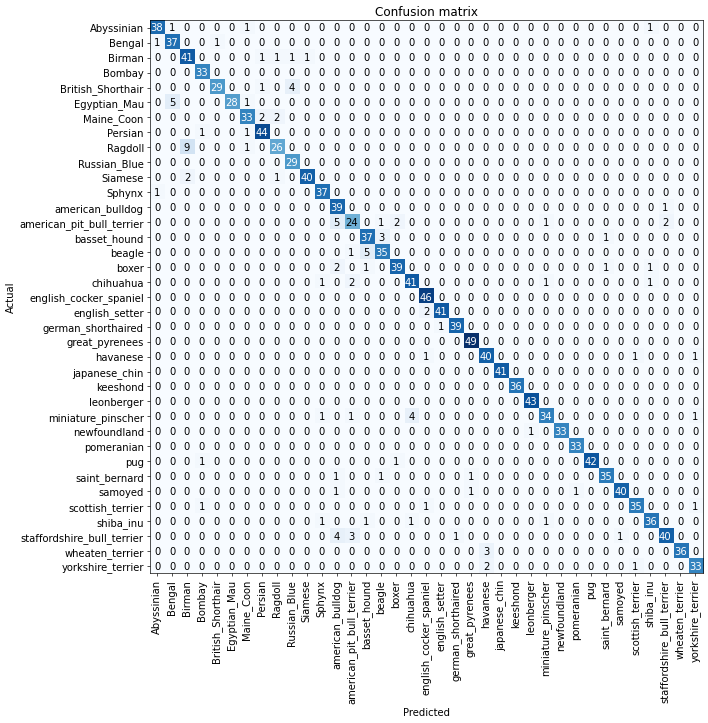

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [51]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 9),
 ('Egyptian_Mau', 'Bengal', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 5),
 ('beagle', 'basset_hound', 5)]

## Improving our model

### Learning rate finder

In [52]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.798824,4.255600,0.442490,00:25


epoch,train_loss,valid_loss,error_rate,time
0,3.225195,2.050002,0.476319,00:32


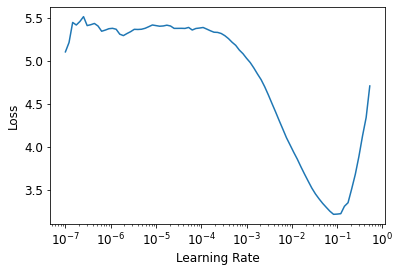

In [53]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [54]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 2.51e-07


In [55]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3) # number 2 parameter here stands for number of epochs

epoch,train_loss,valid_loss,error_rate,time
0,1.311528,0.343824,0.102165,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.527607,0.408235,0.116373,00:32
1,0.332577,0.237850,0.081191,00:32


### Unfreezing and transfer learning

In [56]:
learn = cnn_learner(dls, resnet34, metrics=error_rate) #cnn_learner here by default freezes everything except last layer
learn.fit_one_cycle(3, 3e-3) 

epoch,train_loss,valid_loss,error_rate,time
0,1.125782,0.361892,0.120433,00:24
1,0.525356,0.270072,0.089310,00:24
2,0.319885,0.250268,0.080514,00:24


In [57]:
learn.unfreeze() #so now we can manually unfreeze

(5.248074330665986e-08, 2.5118865210060903e-07)

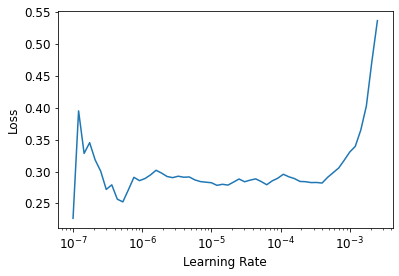

In [58]:
learn.lr_find() #and find a new best learn rate

In [59]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.265545,0.235308,0.075778,00:30
1,0.238956,0.224074,0.073748,00:31
2,0.227883,0.223776,0.070365,00:31
3,0.198647,0.224406,0.073072,00:31
4,0.189395,0.216228,0.077808,00:31
5,0.188625,0.218585,0.074425,00:31


In [60]:
learn.fit_one_cycle??

### Discriminative learning rates

In [61]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.091081,0.328878,0.098782,00:25
1,0.505260,0.243606,0.079161,00:25
2,0.321161,0.227428,0.071042,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.249484,0.227336,0.069012,00:31
1,0.244900,0.220438,0.069689,00:31
2,0.224673,0.216794,0.070365,00:31
3,0.212434,0.214251,0.064953,00:31
4,0.192339,0.214611,0.066982,00:32
5,0.161107,0.215244,0.064276,00:31
6,0.162089,0.219060,0.062246,00:31
7,0.160852,0.213865,0.060893,00:31
8,0.141607,0.213689,0.062923,00:31
9,0.115246,0.211369,0.062246,00:31


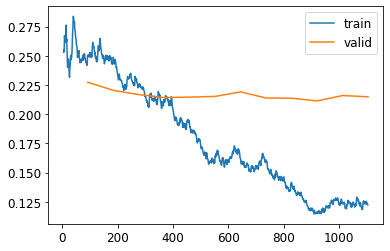

In [62]:
learn.recorder.plot_loss()

### Selecting the number of epochs

### Deeper architectures

In [63]:
from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16() #toFP16 uses hald precision float point so they are less accurate but use less memory
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.436853,0.279270,0.092016,00:32
1,0.604773,0.279927,0.092693,00:33
2,0.426334,0.246259,0.079838,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.264118,0.253652,0.081867,00:41
1,0.310117,0.328026,0.098106,00:42
2,0.236975,0.288282,0.085250,00:42
3,0.151706,0.252784,0.065629,00:42
4,0.097982,0.217221,0.058863,00:42
5,0.063713,0.214521,0.054804,00:42


## Summary

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods is that it adds.
1. Look up the documentation for the Python pathlib module and try using a few methods of the Path class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a DataLoader?
1. What method does fastai provide to help you debug a DataBlock?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the "exp" and "softmax" columns of <<bear_softmax>> yourself (i.e. in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use torch.where to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the fine_tune method do?
1. In Jupyter notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python slice object interpreted when past as a learning rate to fastai?
1. Why is early stopping a poor choice when using one cycle training?
1. What is the difference between resnet 50 and resnet101?
1. What does to_fp16 do?

### Further research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Have a look on the forums and book website to see what other students have achieved with this dataset, and how they did it.